## Introduction:

The 11th ACM International Conference on Web Search and Data Mining (WSDM 2018) is challenging you to build an algorithm that predicts whether a subscription user will churn using a donated dataset from KKBOX. WSDM (pronounced "wisdom") is one of the the premier conferences on web inspired research involving search and data mining. They're committed to publishing original, high quality papers and presentations, with an emphasis on practical but principled novel models.


KKBOX is Asia’s leading music streaming service, holding the world’s most comprehensive Asia-Pop music library with over 30 million tracks. They offer a generous, unlimited version of their service to millions of people, supported by advertising and paid subscriptions. This delicate model is dependent on accurately predicting churn of their paid users.

In this competition you’re tasked to build an algorithm that predicts whether a user will churn after their subscription expires. Currently, the company uses survival analysis techniques to determine the residual membership life time for each subscriber. By adopting different methods, KKBOX anticipates they’ll discover new insights to why users leave so they can be proactive in keeping users dancing.

Tables of the dataset:

__1. train_v2.csv:

    containing the user ids and whether they have churned (is_churn)

__2. transactions_v2.csv:


    transactions of users up until 6/11/2017.

    msno: user id
    payment_method_id: payment method
    payment_plan_days: length of membership plan in days
    plan_list_price: in New Taiwan Dollar (NTD)
    actual_amount_paid: in New Taiwan Dollar (NTD)
    is_auto_renew
    transaction_date: format %Y%m%d
    membership_expire_date: format %Y%m%d
    is_cancel: whether or not the user canceled the membership in this transaction.
    
__3. user_logs_v2.csv:

    daily user logs describing listening behaviors of a user. Data collected until 31/3/2017.

    msno: user id
    date: format %Y%m%d
    num_25: # of songs played less than 25% of the song length
    num_50: # of songs played between 25% to 50% of the song length
    num_75: # of songs played between 50% to 75% of of the song length
    num_985: # of songs played between 75% to 98.5% of the song length
    num_100: # of songs played over 98.5% of the song length
    num_unq: # of unique songs played
    total_secs: total seconds played

__4. members_v3.csv:
    
    user information. Note that not every user in the dataset is available.

    - msno
    - city
    - bd: age. Note: this column has outlier values ranging from -7000 to 2015, please use your judgement.
    - gender
    - registered_via: registration method
    - registration_init_time: format %Y%m%d
    - expiration_date: format %Y%m%d, taken as a snapshot at which the member_v3.csv is extracted. Not representing 
      the actual churn behavior (Updated 13/11/2017)

Compitition link ==> https://www.kaggle.com/c/kkbox-churn-prediction-challenge

In [1]:
## data manipulation
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy import stats
## reading the data 
import json
import zipfile
import csv

from collections import Counter

# ## plotting .. 
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

from datetime import datetime



## warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_train = pd.read_csv('train_v2.csv')

In [3]:
df_train.head()

,msno,is_churn
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1


There are only two columns in this training dataset .. 

msno is a unique user id .. 
is_churn is a churn flag .. 

Count number of values of each unique value of "is_churn" column

In [4]:
Counter(df_train['is_churn']).keys(), Counter(df_train['is_churn']).values()

([0, 1], [883630, 87330])

the non-churn cutsomers are higher ! ;) 

let's check the following:
1. total number of customers in this dataset .. 
2. if there is any missing value .. 

In [5]:
np.shape(df_train)

(970960, 2)

In [6]:
df_train.isnull().any().any()

False

In [7]:
df_train.isnull().sum()

msno        0
is_churn    0
dtype: int64

There are about 970,960 customers in the above dataset .. none of them has empty field ..  

(array([ 883630.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,   87330.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

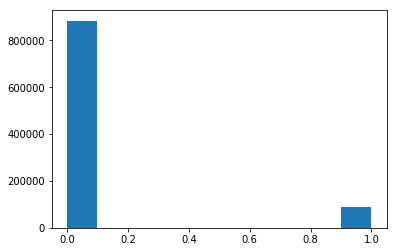

In [8]:
plt.hist(df_train['is_churn'])

## Comment:

the above chart confirms the difference gap between number of churn and no-churn customers .. 

mmmm however, the power of this info. will be magnified if this table is merged with other tables i.e. members, transactions .. to check the behavior of each churn, no-churn customers .. 

let's explore this table first and then merge them ..  

In [9]:
print "% of no churn = ", float(Counter(df_train['is_churn']).values()[0])/len(df_train)*100
print "% of churn = ", float(Counter(df_train['is_churn']).values()[1])/len(df_train)*100

% of no churn =  91.0058086842
% of churn =  8.99419131581


The majority of the customers won't churn ! :) ..

VERY BIASED TRAINING SET ! :S :S

## Transactions dataset:

In [10]:
df_trans = pd.read_csv('transactions_v2.csv')

In [11]:
df_trans.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,++6eU4LsQ3UQ20ILS7d99XK8WbiVgbyYL4FUgzZR134=,32,90,298,298,0,20170131,20170504,0
1,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,149,149,1,20150809,20190412,0
2,+/GXNtXWQVfKrEDqYAzcSw2xSPYMKWNj22m+5XkVQZc=,36,30,180,180,1,20170303,20170422,0
3,+/w1UrZwyka4C9oNH3+Q8fUf3fD8R3EwWrx57ODIsqk=,36,30,180,180,1,20170329,20170331,1
4,+00PGzKTYqtnb65mPKPyeHXcZEwqiEzktpQksaaSC3c=,41,30,99,99,1,20170323,20170423,0


mmm the user_id is also there ;) 

let's check the number of records .. 

In [12]:
np.shape(df_trans)

(1431009, 9)

mmmmm howcome ! ..

number of transactions is greater than number of records in the training data .. 

it means that these are not completely the same customer set .. mmm or I think this makes sense as the single
customer can do more than one transaction !

In [13]:
df = pd.concat([df_train, df_trans])
df.head()

,actual_amount_paid,is_auto_renew,is_cancel,is_churn,membership_expire_date,msno,payment_method_id,payment_plan_days,plan_list_price,transaction_date
0,NaN,NaN,NaN,1.0,NaN,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,1.0,NaN,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,1.0,NaN,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,1.0,NaN,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,1.0,NaN,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,NaN,NaN,NaN,NaN


In [14]:
np.shape(df) #two dataframes are combined 

(2401969, 10)

In [15]:
df = df.reset_index(drop=True)
df.head()

,actual_amount_paid,is_auto_renew,is_cancel,is_churn,membership_expire_date,msno,payment_method_id,payment_plan_days,plan_list_price,transaction_date
0,NaN,NaN,NaN,1.0,NaN,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,1.0,NaN,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,1.0,NaN,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,1.0,NaN,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,1.0,NaN,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,NaN,NaN,NaN,NaN


In [16]:
np.shape(df) 

(2401969, 10)

In [17]:
df_gpby = df.groupby(list(df.columns))
df_gpby.head()

,actual_amount_paid,is_auto_renew,is_cancel,is_churn,membership_expire_date,msno,payment_method_id,payment_plan_days,plan_list_price,transaction_date
0,NaN,NaN,NaN,1.0,NaN,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,1.0,NaN,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,1.0,NaN,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,1.0,NaN,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,1.0,NaN,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,NaN,NaN,NaN,NaN


In [18]:
idx = [x[0] for x in df_gpby.groups.values() if len(x) == 1]

In [19]:
df.reindex(idx)
df.head()

,actual_amount_paid,is_auto_renew,is_cancel,is_churn,membership_expire_date,msno,payment_method_id,payment_plan_days,plan_list_price,transaction_date
0,NaN,NaN,NaN,1.0,NaN,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,1.0,NaN,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,1.0,NaN,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,1.0,NaN,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,1.0,NaN,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,NaN,NaN,NaN,NaN


In [20]:
np.shape(df)

(2401969, 10)

In [21]:
df_ = pd.merge(df_train, df_trans, on=['msno'], how='inner')

In [22]:
np.shape(df_)

(1132036, 10)

## Comment:

mmm this means that the unique values between the merged tables (customers and their transactions) are 1132036 .. this is greater than the number of training data represents the customer which means that the same customer might made more than one transaction in this dataset ! .. 

let's confirm this understanding by checking the duplicate IDs in trans table ..

In [23]:
df_trans.duplicated('msno').any()

True

YES :D .. 

the interpertation above is probably correct :) .. 

the transactions dataset already contains duplicate rows ..  

and in total the two tables collectevily have 2401969 rows .. 

one minute .. 

this collective number is not indicative ! .. as it is none sence to add ALL rows in ALL datasets .. also, the number of inner merging result indicates only those customer's whose transactions are in both datasets .. 

mmm we need a way to list ALL the customers whether they made a transaction reprted in transactions table or not .. 
this gonna be made using (left) outer join .. 

https://www.kaggle.com/rastaman/churn-or-no-churn-exploration-data-analysis

In [24]:
df_train_trans = pd.merge(left = df_train,right = df_trans,how = 'left',on=['msno'])
np.shape(df_train_trans)

(1169418, 10)

Hence, the total number of customers we gonna work on is 1169418 .. 

In [25]:
df_train_trans.head()

,msno,is_churn,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,36.0,30.0,180.0,180.0,0.0,20170311.0,20170411.0,0.0
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,17.0,60.0,0.0,0.0,0.0,20170311.0,20170314.0,0.0
3,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,15.0,90.0,300.0,300.0,0.0,20170314.0,20170615.0,0.0
4,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1,41.0,30.0,149.0,149.0,1.0,20150908.0,20170608.0,0.0


## Exploration of df_train_trans table: 

In [26]:
df_train_trans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1169418 entries, 0 to 1169417
Data columns (total 10 columns):
msno                      1169418 non-null object
is_churn                  1169418 non-null int64
payment_method_id         1132036 non-null float64
payment_plan_days         1132036 non-null float64
plan_list_price           1132036 non-null float64
actual_amount_paid        1132036 non-null float64
is_auto_renew             1132036 non-null float64
transaction_date          1132036 non-null float64
membership_expire_date    1132036 non-null float64
is_cancel                 1132036 non-null float64
dtypes: float64(8), int64(1), object(1)
memory usage: 98.1+ MB


(array([ 1026410.,        0.,        0.,        0.,        0.,        0.,
               0.,        0.,        0.,   143008.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

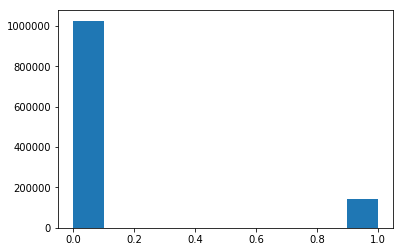

In [27]:
plt.hist(df_train_trans['is_churn'])

In [28]:
df_train.columns

Index([u'msno', u'is_churn'], dtype='object')

## Memebers Dataset:

In [29]:
df_members = pd.read_csv('members_v3.csv')
df_members.head()

,msno,city,bd,gender,registered_via,registration_init_time
0,Rb9UwLQTrxzBVwCB6+bCcSQWZ9JiNLC9dXtM1oEsZA8=,1,0,NaN,11,20110911
1,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,1,0,NaN,7,20110914
2,cV358ssn7a0f7jZOwGNWS07wCKVqxyiImJUX6xcIwKw=,1,0,NaN,11,20110915
3,9bzDeJP6sQodK73K5CBlJ6fgIQzPeLnRl0p5B77XP+g=,1,0,NaN,11,20110915
4,WFLY3s7z4EZsieHCt63XrsdtfTEmJ+2PnnKLH5GY4Tk=,6,32,female,9,20110915


Let's merge the two datasets .. train and members

In [30]:
df_train_member = pd.merge(left = df_train,right = df_members,how = 'left',on=['msno'])
df_train_member.head()

,msno,is_churn,city,bd,gender,registered_via,registration_init_time
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,5.0,28.0,male,3.0,20131223.0
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,13.0,20.0,male,3.0,20131223.0
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,13.0,18.0,male,3.0,20131227.0
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1,1.0,0.0,NaN,7.0,20140109.0
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,13.0,35.0,female,7.0,20140125.0


In [31]:
np.shape(df_train_member)

(970960, 7)

In [32]:
print "% of no churn = ", float(Counter(df_train_member['is_churn']).values()[0])/len(df_train_member)*100
print "% of churn = ", float(Counter(df_train_member['is_churn']).values()[1])/len(df_train_member)*100

% of no churn =  91.0058086842
% of churn =  8.99419131581


The same % of the original training data contains only list of customers and their corresponding churn flag 

## Changing the format of vars to the correct type .. 

stems from this notebook ==> 

https://www.kaggle.com/rastaman/churn-or-no-churn-exploration-data-analysis

1. Changing the type of city, registered_via from float to int .. 

In [33]:
df_train_member['city'] = df_train_member.city.apply(lambda x: int(x) if pd.notnull(x) else "NAN")
df_train_member['city'].head()

0     5
1    13
2    13
3     1
4    13
Name: city, dtype: object

In [34]:
df_train_member['registered_via'] = df_train_member.registered_via.apply(lambda x: int(x) if pd.notnull(x) else "NAN")
df_train_member['registered_via'].head()

0    3
1    3
2    3
3    7
4    7
Name: registered_via, dtype: object

2. Changing the format of dates to date:

In [35]:
df_train_member['registration_init_time'] = df_train_member.registration_init_time.apply(lambda x: datetime.strptime(str(int(x)), "%Y%m%d").date()
                                                                                        if pd.notnull(x) else "NAN")

In [36]:
df_train_member['registration_init_time'].head()

0    2013-12-23
1    2013-12-23
2    2013-12-27
3    2014-01-09
4    2014-01-25
Name: registration_init_time, dtype: object

In [37]:
df_train_trans['membership_expire_date'] = df_train_trans.membership_expire_date.apply(lambda x: datetime.strptime(str(int(x)), "%Y%m%d").date()
                                                                                        if pd.notnull(x) else "NAN")

In [38]:
df_train_trans['membership_expire_date'].head()

0           NAN
1    2017-04-11
2    2017-03-14
3    2017-06-15
4    2017-06-08
Name: membership_expire_date, dtype: object

## Data Viz:

## 1. Members dataset .. 


Text(0.5,1,u'Frequency of City Count in Members Data Set')

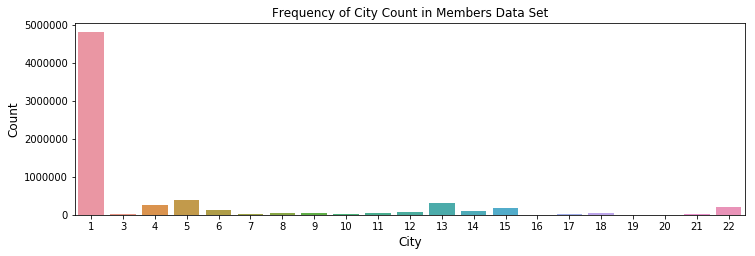

In [39]:
# City 

plt.figure(figsize=(12,12))
plt.subplot(311)
sns.countplot(x="city", data = df_members)

plt.ylabel('Count', fontsize=12)
plt.xlabel('City', fontsize=12)
plt.title("Frequency of City Count in Members Data Set", fontsize=12)

In [40]:
city_count = Counter(df_members['city']).most_common()
city_count

[(1, 4804326),
 (5, 385069),
 (13, 320978),
 (4, 246848),
 (22, 210407),
 (15, 190213),
 (6, 135200),
 (14, 89940),
 (12, 66843),
 (9, 47639),
 (11, 47489),
 (8, 45975),
 (18, 38039),
 (10, 32482),
 (21, 30837),
 (17, 27772),
 (3, 27282),
 (7, 11610),
 (16, 5092),
 (20, 4233),
 (19, 1199)]

The highest number of members are in the 1st city .. followed by city # 5 and luckily we don't have NANs here ;) 

Text(0.5,1,u'Frequency of Registered Via Count in Members Data Set')

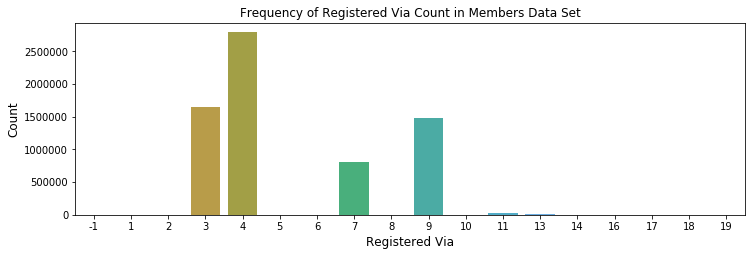

In [41]:
#Registered

#adjust the plotting area settings 
plt.figure(figsize=(12,12))
plt.subplot(312)

sns.countplot(x="registered_via", data = df_members)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Registered Via', fontsize=12)
plt.title("Frequency of Registered Via Count in Members Data Set", fontsize=12)

In [42]:
reg_count = Counter(df_members['registered_via']).most_common()
reg_count

[(4, 2793213),
 (3, 1643208),
 (9, 1482863),
 (7, 805895),
 (11, 25047),
 (13, 5455),
 (8, 3982),
 (5, 3115),
 (17, 1494),
 (2, 1452),
 (6, 1213),
 (19, 974),
 (16, 888),
 (14, 615),
 (1, 43),
 (10, 10),
 (18, 5),
 (-1, 1)]

Text(0.5,1,u'Frequency of Gender Count in Members Data Set')

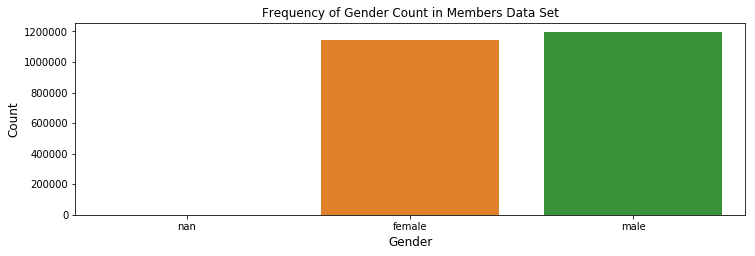

In [43]:
#Gender

plt.figure(figsize=(12,12))
plt.subplot(313)

gender__ = df_members['gender'].unique()
sns.countplot(x = "gender", data = df_members, order = gender__)

plt.ylabel('Count', fontsize=12)
plt.xlabel('Gender', fontsize=12)
plt.title("Frequency of Gender Count in Members Data Set", fontsize=12)

In [44]:
gender_count = Counter(df_members['gender']).most_common()
gender_count

[(nan, 4429505), ('male', 1195355), ('female', 1144613)]

## 2. Merged dataset ..
Train + members ..

Text(0.5,1,u'Frequency of City Count')

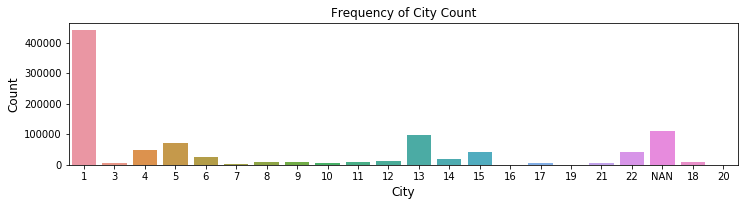

In [45]:
plt.figure(figsize=(12,12))
plt.subplot(411)
city_order = df_train_member['city'].unique()  ## extract unique vals
city_order=sorted(city_order, key=lambda x: float(x))
sns.countplot(x="city", data=df_train_member, order = city_order)
plt.ylabel('Count', fontsize=12)
plt.xlabel('City', fontsize=12)
plt.title("Frequency of City Count", fontsize=12)

Print every city and its corresponding count .. [ordered]

There is no City # 2 in this dataset ! :S .. 
and they are in total 21 city .. 

In [46]:
city_count = Counter(df_train_member['city']).most_common()
print("City Count " +str(city_count))

City Count [(1, 442598), ('NAN', 109993), (13, 97136), (5, 70706), (4, 47227), (15, 43187), (22, 41991), (6, 26066), (14, 20013), (12, 11383), (9, 9526), (11, 9138), (18, 7792), (8, 7589), (10, 6470), (17, 5476), (21, 5199), (3, 5057), (7, 2652), (16, 944), (20, 677), (19, 140)]


The 1st city has the highest number of people .. followed by the NANs :S .. 

these are sad news as NANs are empty cells :S :S ..

Text(0.5,1,u'Frequency of Registered Via Count')

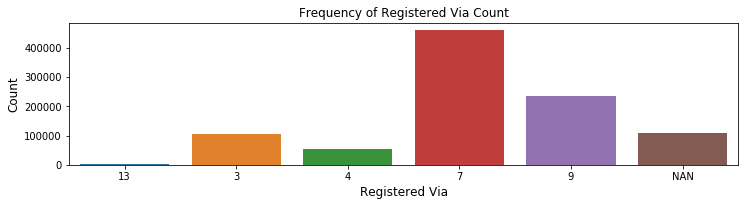

In [47]:
#Registered Via Count
plt.figure(figsize=(12,12))
plt.subplot(412)
R_V_order = df_train_member['registered_via'].unique()
R_V_order = sorted(R_V_order, key=lambda x: str(x))
# R_V_order = sorted(R_V_order, key=lambda x: float(x))
sns.countplot(x="registered_via", data=df_train_member,order = R_V_order)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Registered Via', fontsize=12)
plt.title("Frequency of Registered Via Count", fontsize=12)

In [48]:
RV_count = Counter(df_train_member['registered_via']).most_common()
RV_count

[(7, 462684),
 (9, 235689),
 ('NAN', 109993),
 (3, 106459),
 (4, 52744),
 (13, 3391)]

Registeration count is at its max. value at 7 .. then 9 .. and unfortunately, followed by NANs

Text(0.5,1,u'Frequency of Gender Count')

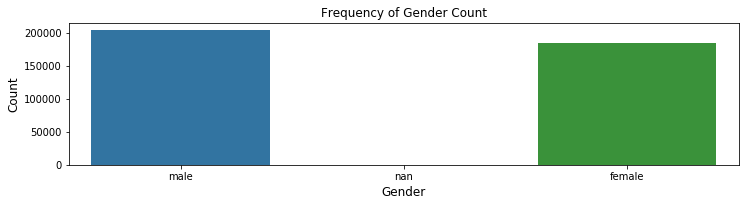

In [49]:
#Gender count
plt.figure(figsize=(12,12))
plt.subplot(413)
gender_ = df_train_member['gender'].unique()
sns.countplot(x = "gender", data = df_train_member, order = gender_)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Gender', fontsize=12)
plt.title("Frequency of Gender Count", fontsize=12)

In [50]:
gender_count = Counter(df_train_member['gender']).most_common()
gender_count

[(nan, 582055), ('male', 204561), ('female', 184344)]

Males are higher than females .. However, the larger portion is NAs 582055 .. 

In [51]:
df_train_member['gender'].isnull().any().any(), df_train_member['gender'].isnull().sum()

(True, 582055)

3. Registration_init_time 

Let's make data exploration for this variable .. by extracting the 'Year' part and analyze it ! 

In [52]:
df_train_member['registration_init_time_year'] = pd.DatetimeIndex(df_train_member['registration_init_time']).year
df_train_member['registration_init_time_year'].unique()

array([ 2013.,  2014.,    nan,  2015.,  2016.,  2017.,  2004.,  2005.,
        2006.,  2007.,  2008.,  2009.,  2010.,  2011.,  2012.])

In [53]:
df_train_member['registration_init_time_year'] = df_train_member.registration_init_time_year.apply(lambda x: int(x) if pd.notnull(x) else "NAN" )
df_train_member['registration_init_time_year'].head()

0    2013
1    2013
2    2013
3    2014
4    2014
Name: registration_init_time_year, dtype: object

In [54]:
year_count = df_train_member['registration_init_time_year'].value_counts()
year_count

2016    195184
2015    154376
2013    113444
NAN     109993
2014     89332
2012     74495
2011     60698
2010     38640
2017     33230
2007     26158
2006     18048
2008     17685
2009     15731
2005     15616
2004      8330
Name: registration_init_time_year, dtype: int64

Text(0.5,1,u'Yearly Trend of registration_init_time')

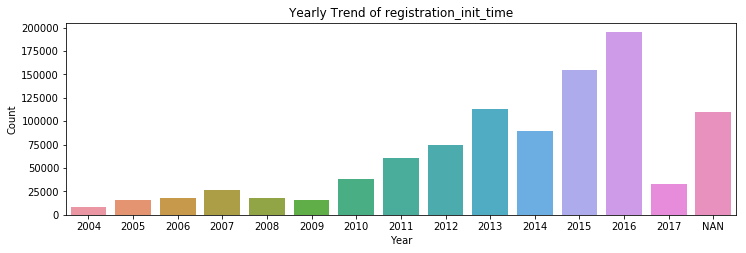

In [55]:
plt.figure(figsize=(12,12))
plt.subplot(311)
year_order = df_train_member['registration_init_time_year'].unique()
year_order=sorted(year_order, key=lambda x: str(x))
sns.barplot(year_count.index, year_count.values, order = year_order)
plt.xlabel('Year')
plt.ylabel('Count')
plt.title("Yearly Trend of registration_init_time", fontsize=12)

There is an increasing trend in the registeration yearly .. 

except a drop in 2014 and again in 2017 .. 

In [56]:
year_count_2 = Counter(df_train_member['registration_init_time_year']).most_common()
year_count_2

[(2016, 195184),
 (2015, 154376),
 (2013, 113444),
 ('NAN', 109993),
 (2014, 89332),
 (2012, 74495),
 (2011, 60698),
 (2010, 38640),
 (2017, 33230),
 (2007, 26158),
 (2006, 18048),
 (2008, 17685),
 (2009, 15731),
 (2005, 15616),
 (2004, 8330)]

the year that has the highest init count is 2016 with 195184 member .. 
followed by 2015 with 154376 member .. 

NAN count ranked 4th .. which is a huge number !

Let's check the count in Month level .. 

In [57]:
df_train_member['registration_init_time_month'] = pd.DatetimeIndex(df_train_member['registration_init_time']).month
df_train_member['registration_init_time_month'].unique()

array([ 12.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,  nan,   9.,
        10.,  11.])

In [58]:
df_train_member['registration_init_time_month'] = df_train_member.registration_init_time_month.apply(lambda x: int(x) if pd.notnull(x) else "NAN" )
df_train_member['registration_init_time_month'].head()

0    12
1    12
2    12
3     1
4     1
Name: registration_init_time_month, dtype: object

In [59]:
month_count = df_train_member['registration_init_time_month'].value_counts()
month_count

NAN    109993
1       89640
2       85628
12      81230
10      80528
11      77988
8       75068
7       73204
9       67985
3       65938
6       58582
5       55444
4       49732
Name: registration_init_time_month, dtype: int64

Text(0.5,1,u'Monthly Trend of registration_init_time')

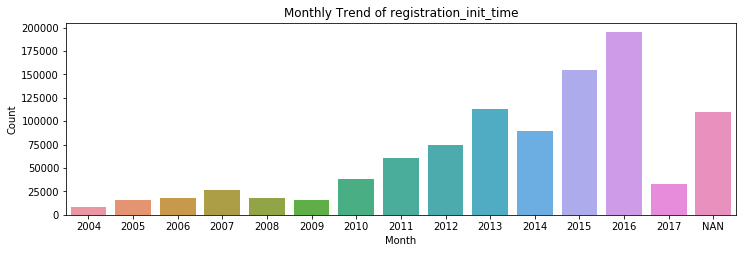

In [60]:
plt.figure(figsize=(12,12))
plt.subplot(311)
month_order = df_train_member['registration_init_time_month'].unique()
month_order=sorted(year_order, key=lambda x: str(x))
sns.barplot(year_count.index, year_count.values, order = month_order)
plt.xlabel('Month')
plt.ylabel('Count')
plt.title("Monthly Trend of registration_init_time", fontsize=12)

Registeration monthly are higher in the beginning and end of the year .. however, in between have fewer number of registeration .. 

In [61]:
month_count_2 = Counter(df_train_member['registration_init_time_month']).most_common()
month_count_2

[('NAN', 109993),
 (1, 89640),
 (2, 85628),
 (12, 81230),
 (10, 80528),
 (11, 77988),
 (8, 75068),
 (7, 73204),
 (9, 67985),
 (3, 65938),
 (6, 58582),
 (5, 55444),
 (4, 49732)]

mmmm the highest count is related to NANs !! :S .. 

followed by Jan, then Feb and April has the least count .. 

Let's check the trends per day ..  

In [62]:
df_train_member['registration_init_time_day'] = pd.DatetimeIndex(df_train_member['registration_init_time']).weekday_name
df_train_member['registration_init_time_day'].unique()

array(['Monday', 'Friday', 'Thursday', 'Saturday', 'Sunday', 'Wednesday',
       'Tuesday', nan], dtype=object)

In [63]:
day_count = df_train_member['registration_init_time_day'].value_counts()
day_count

Saturday     139268
Friday       123638
Sunday       122187
Monday       119893
Tuesday      119784
Thursday     118881
Wednesday    117316
Name: registration_init_time_day, dtype: int64

Text(0.5,1,u'Daily Trend of registration_init_time')

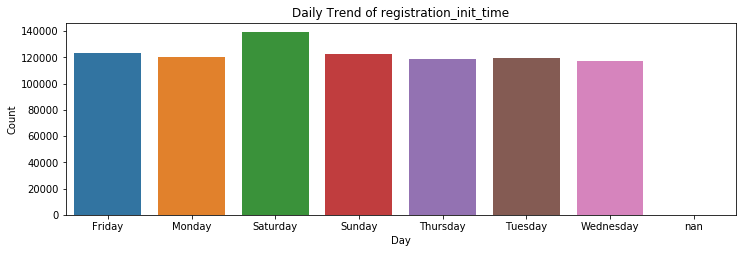

In [64]:
plt.figure(figsize=(12,12))
plt.subplot(311)
day_order = df_train_member['registration_init_time_day'].unique()
day_order=sorted(day_order, key=lambda x: str(x))
sns.barplot(day_count.index, day_count.values, order = day_order)
plt.xlabel('Day')
plt.ylabel('Count')
plt.title("Daily Trend of registration_init_time", fontsize=12)

In [65]:
day_count_2 = Counter(df_train_member['registration_init_time_day']).most_common()
day_count_2

[('Saturday', 139268),
 ('Friday', 123638),
 ('Sunday', 122187),
 ('Monday', 119893),
 ('Tuesday', 119784),
 ('Thursday', 118881),
 ('Wednesday', 117316),
 (nan, 109993)]

The peak is on Sat. followed by Friday .. luckily the number of NANs in this dataset is smaller .. 

This means that registerations have peaks in the weekend than in weekdays .. 

## Conclusion:

1. In general members - city data is cleaner then the merged dataset .. as it doesn't contain NANs 
2. Same case with "Registered" dataset .. and there are many "registered via" missing in the merged dataset
3. Number of missing data in Members dataset is larger then the merged dataset however, the gap between number of males and females is less

## Birthdate column:

In [66]:
birth_date = df_train_member['bd'].value_counts()
birth_date.head(3), birth_date.tail(3)

(0.0     473729
 27.0     22786
 26.0     21829
 Name: bd, dtype: int64,  1022.0    1
  837.0     1
 -38.0      1
 Name: bd, dtype: int64)

mmm there is something wrong ! ..

The birthday contains negative numbers ! .. and the highest count is in birthday of ZERO ! ..

In [67]:
## apply is important .. 

df_train_member['bd'] = df_train_member.bd.apply(lambda x: int(x) if pd.notnull(x) else "NAN" )

bd_count = Counter(df_train_member['bd']).most_common()
bd_count

[(0, 473729),
 ('NAN', 109993),
 (27, 22786),
 (26, 21829),
 (25, 20651),
 (24, 20296),
 (28, 20244),
 (29, 19533),
 (23, 19238),
 (22, 18035),
 (30, 17175),
 (21, 15633),
 (31, 15123),
 (32, 14406),
 (20, 13678),
 (33, 13229),
 (34, 12154),
 (35, 10959),
 (36, 9985),
 (19, 9861),
 (37, 8858),
 (18, 8207),
 (38, 7679),
 (39, 6651),
 (17, 5913),
 (40, 5663),
 (41, 5221),
 (42, 4305),
 (43, 3723),
 (44, 3266),
 (46, 3015),
 (45, 3010),
 (47, 2889),
 (16, 2544),
 (48, 2539),
 (49, 2320),
 (50, 2027),
 (51, 1970),
 (52, 1748),
 (53, 1445),
 (54, 1159),
 (55, 1021),
 (15, 848),
 (56, 844),
 (57, 736),
 (58, 541),
 (59, 510),
 (60, 455),
 (61, 390),
 (62, 309),
 (14, 282),
 (63, 258),
 (64, 193),
 (65, 171),
 (66, 147),
 (67, 140),
 (68, 90),
 (106, 81),
 (69, 67),
 (117, 65),
 (13, 63),
 (70, 57),
 (112, 52),
 (72, 42),
 (71, 40),
 (73, 37),
 (74, 31),
 (77, 30),
 (12, 23),
 (75, 23),
 (76, 23),
 (102, 23),
 (84, 22),
 (1, 21),
 (105, 21),
 (95, 19),
 (91, 18),
 (5, 16),
 (89, 16),
 (6, 15)

It seems we have big problem with the data in this column as the majority goes to either birthday of zero or NAN !! :S .. 

and luckily the -ve values have small counts .. 

## Age values imputation .. 

To solve such issues let's apply what is proposed in this notebook ==> 

https://www.kaggle.com/rastaman/churn-or-no-churn-exploration-data-analysis

- First we can make all Birth date <= 1 to -99999( just a large -ve number) as I don't think it would make a difference
- Next we can also ignore the Birth Date >= 100



In [68]:
df_train_member.loc[(df_train_member['bd'] <= 1), 'bd'] = -99999

In [69]:
df_train_member.loc[(df_train_member['bd'] > 100), 'bd'] = -99999

In [70]:
bd_count_ = Counter(df_train_member['bd']).most_common()
bd_count_

[(-99999, 584266),
 (27, 22786),
 (26, 21829),
 (25, 20651),
 (24, 20296),
 (28, 20244),
 (29, 19533),
 (23, 19238),
 (22, 18035),
 (30, 17175),
 (21, 15633),
 (31, 15123),
 (32, 14406),
 (20, 13678),
 (33, 13229),
 (34, 12154),
 (35, 10959),
 (36, 9985),
 (19, 9861),
 (37, 8858),
 (18, 8207),
 (38, 7679),
 (39, 6651),
 (17, 5913),
 (40, 5663),
 (41, 5221),
 (42, 4305),
 (43, 3723),
 (44, 3266),
 (46, 3015),
 (45, 3010),
 (47, 2889),
 (16, 2544),
 (48, 2539),
 (49, 2320),
 (50, 2027),
 (51, 1970),
 (52, 1748),
 (53, 1445),
 (54, 1159),
 (55, 1021),
 (15, 848),
 (56, 844),
 (57, 736),
 (58, 541),
 (59, 510),
 (60, 455),
 (61, 390),
 (62, 309),
 (14, 282),
 (63, 258),
 (64, 193),
 (65, 171),
 (66, 147),
 (67, 140),
 (68, 90),
 (69, 67),
 (13, 63),
 (70, 57),
 (72, 42),
 (71, 40),
 (73, 37),
 (74, 31),
 (77, 30),
 (12, 23),
 (75, 23),
 (76, 23),
 (84, 22),
 (95, 19),
 (91, 18),
 (5, 16),
 (89, 16),
 (6, 15),
 (92, 14),
 (7, 13),
 (79, 13),
 (81, 13),
 (78, 12),
 (10, 11),
 (97, 11),
 (100

Issue is solved :) 

Text(0.5,0,u'BD')

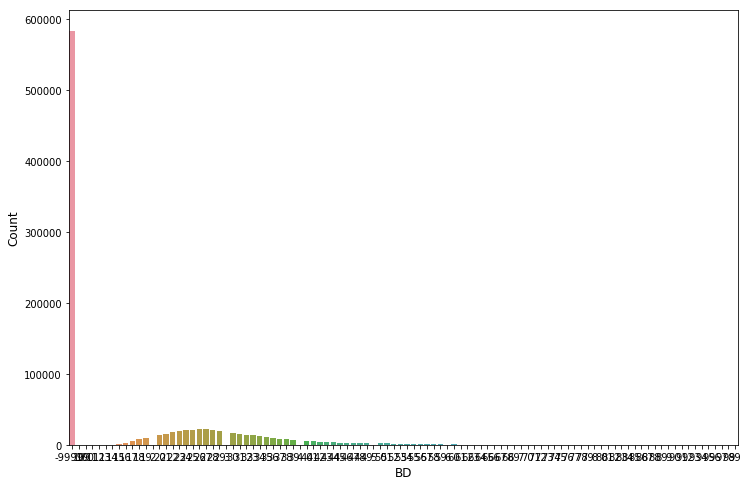

In [74]:
#Birth Date 

plt.figure(figsize=(12,8))
bd_order = df_train_member['bd'].unique()
bd_order = sorted(bd_order, key=lambda x: str(x))

sns.countplot(x="bd", data=df_train_member , order = bd_order)

plt.ylabel('Count', fontsize=12)
plt.xlabel('BD', fontsize=12)

In [76]:
bd_count = Counter(df_train_member['bd']).most_common()
bd_count

[(-99999, 584266),
 (27, 22786),
 (26, 21829),
 (25, 20651),
 (24, 20296),
 (28, 20244),
 (29, 19533),
 (23, 19238),
 (22, 18035),
 (30, 17175),
 (21, 15633),
 (31, 15123),
 (32, 14406),
 (20, 13678),
 (33, 13229),
 (34, 12154),
 (35, 10959),
 (36, 9985),
 (19, 9861),
 (37, 8858),
 (18, 8207),
 (38, 7679),
 (39, 6651),
 (17, 5913),
 (40, 5663),
 (41, 5221),
 (42, 4305),
 (43, 3723),
 (44, 3266),
 (46, 3015),
 (45, 3010),
 (47, 2889),
 (16, 2544),
 (48, 2539),
 (49, 2320),
 (50, 2027),
 (51, 1970),
 (52, 1748),
 (53, 1445),
 (54, 1159),
 (55, 1021),
 (15, 848),
 (56, 844),
 (57, 736),
 (58, 541),
 (59, 510),
 (60, 455),
 (61, 390),
 (62, 309),
 (14, 282),
 (63, 258),
 (64, 193),
 (65, 171),
 (66, 147),
 (67, 140),
 (68, 90),
 (69, 67),
 (13, 63),
 (70, 57),
 (72, 42),
 (71, 40),
 (73, 37),
 (74, 31),
 (77, 30),
 (12, 23),
 (75, 23),
 (76, 23),
 (84, 22),
 (95, 19),
 (91, 18),
 (5, 16),
 (89, 16),
 (6, 15),
 (92, 14),
 (7, 13),
 (79, 13),
 (81, 13),
 (78, 12),
 (10, 11),
 (97, 11),
 (100

mmmm well, let's remove the NANs that has the above peak .. and replot ..

In [77]:
bd_ = df_train_member[(df_train_member.bd != "NAN") & (df_train_member.bd != -99990)]
bd_  # carries a new table without any outlier .. 

Text(0.5,1,u'Frequency of BD Count without ouliers and NAN values')

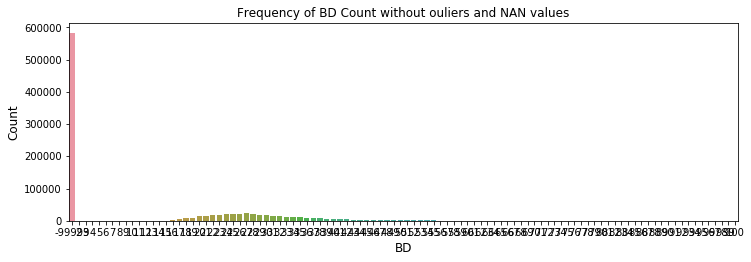

In [79]:
plt.figure(figsize=(12,8))
plt.subplot(211)

bd_order_2 = bd_['bd'].unique()
bd_order_2 = sorted(bd_order_2, key=lambda x: float(x))
sns.countplot(x="bd", data=bd_ , order = bd_order_2)

plt.ylabel('Count', fontsize=12)
plt.xlabel('BD', fontsize=12)

plt.title("Frequency of BD Count without ouliers and NAN values", fontsize=12)